**Task-2**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
# Load datasets
customers = pd.read_csv("/content/drive/My Drive/Zeotap/Customers.csv")
products = pd.read_csv("/content/drive/My Drive/Zeotap/Products.csv")
transactions = pd.read_csv("/content/drive/My Drive/Zeotap/Transactions.csv")

In [14]:
# Remove ï»¿ from column names
customers.columns = customers.columns.str.replace('ï»¿', '')
products.columns = products.columns.str.replace('ï»¿', '')
transactions.columns = transactions.columns.str.replace('ï»¿', '')

# Check for 'CustomerID' column in both DataFrames (Verification)
print("Columns in customers:", customers.columns)
print("Columns in transactions:", transactions.columns)


Columns in customers: Index(['CustomerID', 'CustomerName', 'Region', 'SignupDate'], dtype='object')
Columns in transactions: Index(['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate',
       'Quantity', 'TotalValue', 'Price'],
      dtype='object')


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# Merge datasets
merged = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Create customer-level features
customer_features = merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Category': lambda x: x.mode()[0],  # Most common category
    'Region': 'first',
}).reset_index()

# Convert categorical features to one-hot encoding
customer_features = pd.get_dummies(customer_features, columns=['Category', 'Region'], drop_first=True)

# Normalize data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))

# Compute similarity matrix
similarity_matrix = cosine_similarity(normalized_features)

# Get top 3 similar customers
lookalike_results = {}
for i in range(len(customer_features)):
    customer_id = customer_features.iloc[i]['CustomerID']
    similarity_scores = list(enumerate(similarity_matrix[i]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:4]
    lookalike_results[customer_id] = [(customer_features.iloc[j[0]]['CustomerID'], j[1]) for j in similarity_scores]

# Save results to CSV
lookalike_df = pd.DataFrame({
    "CustomerID": lookalike_results.keys(),
    "Lookalike1": [x[0][0] for x in lookalike_results.values()],
    "Score1": [x[0][1] for x in lookalike_results.values()],
    "Lookalike2": [x[1][0] for x in lookalike_results.values()],
    "Score2": [x[1][1] for x in lookalike_results.values()],
    "Lookalike3": [x[2][0] for x in lookalike_results.values()],
    "Score3": [x[2][1] for x in lookalike_results.values()],
})

# Display the first few rows of the lookalike customer results
print(lookalike_df.head())

# Save results to CSV in Google Drive
lookalike_df.to_csv("/content/drive/My Drive/Zeotap/FirstName_LastName_Lookalike.csv", index=False)

  CustomerID Lookalike1    Score1 Lookalike2    Score2 Lookalike3    Score3
0      C0001      C0184  0.998092      C0048  0.994759      C0190  0.989566
1      C0002      C0088  0.998319      C0092  0.966723      C0106  0.950399
2      C0003      C0076  0.981548      C0052  0.971390      C0031  0.963856
3      C0004      C0169  0.979381      C0087  0.973812      C0165  0.968460
4      C0005      C0186  0.998515      C0140  0.993755      C0146  0.992292


In [13]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from datetime import datetime



# Merge datasets on CustomerID and ProductID
merged = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Feature Engineering
# 1. Total spent by customer
total_spent = merged.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spent.columns = ['CustomerID', 'TotalSpent']

# 2. Recency of last transaction
merged['TransactionDate'] = pd.to_datetime(merged['TransactionDate'])
most_recent = merged.groupby('CustomerID')['TransactionDate'].max().reset_index()
most_recent.columns = ['CustomerID', 'LastPurchaseDate']
most_recent['Recency'] = (datetime.now() - most_recent['LastPurchaseDate']).dt.days

# 3. Join the features into a single DataFrame
customer_features = total_spent.merge(most_recent[['CustomerID', 'Recency']], on='CustomerID')

# 4. Normalize features
scaler = StandardScaler()
customer_features[['TotalSpent', 'Recency']] = scaler.fit_transform(customer_features[['TotalSpent', 'Recency']])

# Calculate similarity matrix (cosine similarity)
similarity_matrix = cosine_similarity(customer_features[['TotalSpent', 'Recency']])

# Function to get top 3 lookalikes for each customer
def get_lookalikes(similarity_matrix, customer_id, n_top=3):
    customer_index = customers[customers['CustomerID'] == customer_id].index[0]
    similarities = similarity_matrix[customer_index]
    # Exclude self-similarity by setting the similarity of the customer to 0
    similarities[customer_index] = 0
    top_indices = similarities.argsort()[-n_top:][::-1]  # Top 3 indices with highest similarity
    top_customers = customers.iloc[top_indices]['CustomerID'].values
    top_scores = similarities[top_indices]
    return list(zip(top_customers, top_scores))

# Generate lookalike recommendations for first 20 customers
lookalikes = {}
for customer_id in customers['CustomerID'][:20]:
    lookalikes[customer_id] = get_lookalikes(similarity_matrix, customer_id)

# Save results to Lookalike.csv
lookalike_data = []
for customer_id, recommendations in lookalikes.items():
    for rank, (similar_customer, score) in enumerate(recommendations, 1):
        lookalike_data.append([customer_id, f'Lookalike_CustomerID_{rank}', similar_customer, f'Similarity_Score_{rank}', score])

lookalike_df = pd.DataFrame(lookalike_data, columns=['CustomerID', 'LookalikeCustomerID', 'SimilarCustomerID', 'SimilarityScore', 'Score'])

# Display the first few rows of the lookalike customer results
print(lookalike_df.head())

# Save results to CSV in Google Drive
lookalike_df.to_csv("/content/drive/My Drive/Zeotap/Lookalike.csv", index=False)


  CustomerID     LookalikeCustomerID SimilarCustomerID     SimilarityScore  \
0      C0001  Lookalike_CustomerID_1             C0092  Similarity_Score_1   
1      C0001  Lookalike_CustomerID_2             C0147  Similarity_Score_2   
2      C0001  Lookalike_CustomerID_3             C0115  Similarity_Score_3   
3      C0002  Lookalike_CustomerID_1             C0044  Similarity_Score_1   
4      C0002  Lookalike_CustomerID_2             C0172  Similarity_Score_2   

      Score  
0  0.999267  
1  0.999224  
2  0.998736  
3  0.999985  
4  0.999790  


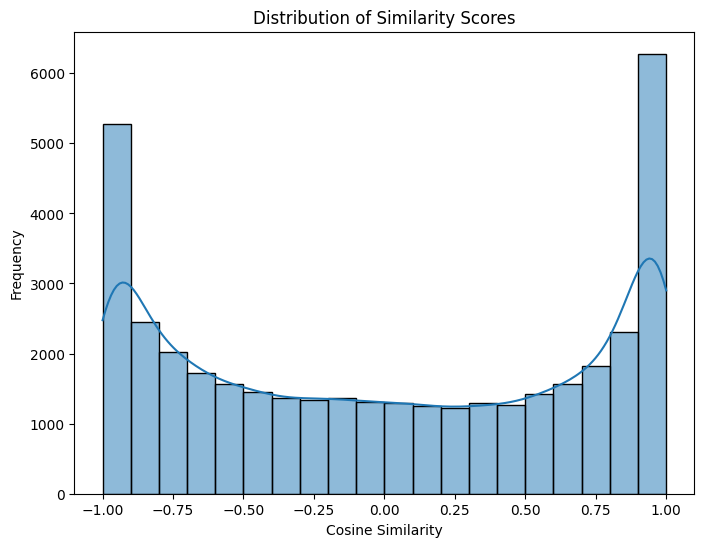

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten the similarity matrix for visualization
similarity_scores = similarity_matrix.flatten()

plt.figure(figsize=(8, 6))
sns.histplot(similarity_scores, kde=True, bins=20)
plt.title('Distribution of Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()
